In [1]:
import h5py
import scipy
import scipy.io
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.stats import norm

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow
tfl = tf.linalg

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
balls = scipy.io.loadmat('/Users/robertofiermonte/bouncing_balls_training_data.mat')
y = np.clip(np.stack([b for b in balls['Data'].flatten()]), 0.001, 0.999)

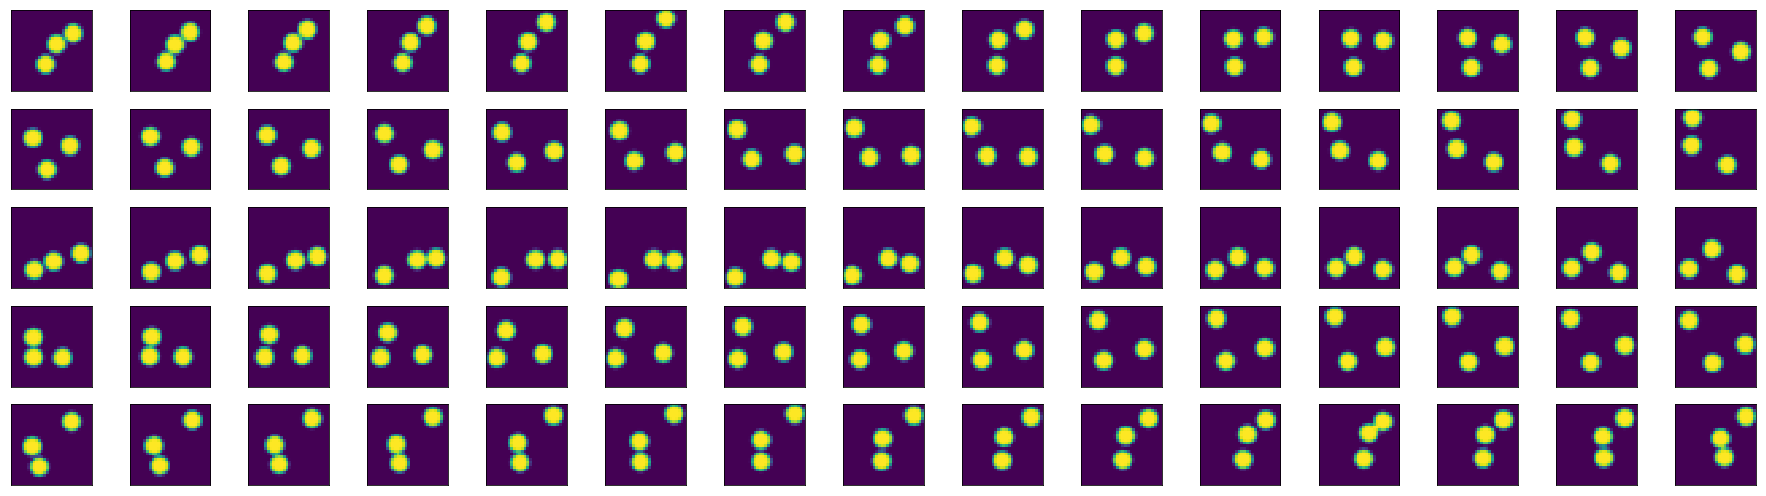

In [3]:
fig, axs = plt.subplots(nrows=5, ncols=15, figsize=(25, 7))
for i in range(5):
    for j in range(15):
        axs[i][j].imshow(np.reshape(y[i], [100, 30, 30])[j])
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
# noise = norm.rvs(0, 1.2, y.shape)
# y_noisy = np.clip(norm.cdf(norm.ppf(y) + noise), 0.001, 0.999)
# training_data = norm.ppf(y_noisy)

In [5]:
# fig, axs = plt.subplots(nrows=5, ncols=15, figsize=(25, 7))
# for i in range(5):
#     for j in range(15):
#         axs[i][j].imshow(np.reshape(y_noisy[i], [100, 30, 30])[j])
#         axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
# plt.tight_layout()
# plt.show()

In [6]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [7]:
class GaussianVideoCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, hidden_size, std, reuse=None):       
        super(GaussianVideoCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._hidden_size = hidden_size
        self._std = std[None, None]

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, state = self._cell(inputs, state)
        hidden = tf.layers.dense(state, self._hidden_size, tf.nn.relu)
        hidden = tf.layers.dense(hidden, self._hidden_size, tf.nn.relu)
        mean = tf.layers.dense(hidden, self._event_size)
        n_samples = mean.shape[0]
        return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingVideoCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingVideoCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)

In [8]:
class RobustVideoARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=100, batch_size=1):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 900                                             # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Sy = n_samples                                      # Sy
        self._Z = 50                                              # Z
        
        self._gen_std = (tf.get_variable('generative_std', shape=(), 
                                         initializer=tf.constant_initializer(0.7)))
        
        self._trans_std = tf.nn.softplus(tf.get_variable('transitional_std', shape=(),
                                         initializer=tf.constant_initializer(1)))
        
        self._cell = tf.contrib.rnn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianVideoCell(self._cell, self._D, 200, self._trans_std)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self.make_posterior_y
        self.make_posterior_z
        self.compute_elbo
        self.E_step
        self.M_step
        
#         self.make_forward_posterior
#         self.make_forward_parameters
#         self.make_forward_kl_y
#         self.compute_elbo_forward
#         self.forward_E_step
#         self.forward_M_step
    
    @define_scope
    def make_posterior_z(self):
        self._post_cell_z = tf.contrib.rnn.GRUBlockCell(self._H)
        _, h = tf.nn.dynamic_rnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means, scale_diag=stds)
    
    @define_scope
    def make_kl_z(self):
        q = self.make_posterior_z
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(q, p))
    
    @define_scope
    def make_posterior_y(self):
        self._post_cell_f = tf.contrib.rnn.GRUBlockCell(self._H)
        self._post_cell_b = tf.contrib.rnn.GRUBlockCell(self._H)
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(
                                                self._post_cell_f, self._post_cell_b, 
                                                inputs=self._data, dtype=tf.float32
        )
        
        hidden = tf.concat([out_f, out_b], 2)
        means = tf.layers.dense(hidden, 200, tf.nn.relu)
        means = tf.layers.dense(means, 200, tf.nn.relu)
        means = tf.layers.dense(means, self._D)
        means = tf.identity(means, name='post_means')
        self._post_std = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(1), 
                                        name='post_stddev'))
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._post_std)
    
    @define_scope
    def make_entropy_y(self):
        return tf.reduce_sum(self.make_posterior_y.entropy())
    
    @define_scope
    def make_kl_y(self):
        entropy = self.make_entropy_y
        const = self._D * np.log(2 * np.pi)
        means = self.make_transitional       # Sz x Sy x B x T x D
        
        exponent_trans = tf.square(self._code_y[None, ...] - means)/(2 * tf.square(self._trans_std))
        norm_trans = self._B * self._T * (tfl.logdet(tf.square(self._trans_std) * np.eye(self._D)) + const) / 2
        exp_trans = tf.reduce_sum(tf.reduce_mean(exponent_trans, [0, 1]))   
        return - entropy + exp_trans + norm_trans
    
    @define_scope
    def make_transitional(self):
        code_z = tf.reshape(tf.tile(self._code_z[:, None, ...], [1, self._Sy, 1, 1]), [-1, self._Z])
        code_y = tf.reshape(tf.tile(self._code_y[None, ...], [self._Sz, 1, 1, 1, 1]), [-1, self._T, self._D])
        hidden = tf.layers.dense(code_z, 200, tf.nn.relu)
        hidden = tf.layers.dense(hidden, self._H)
        
        inputs = tf.concat([tf.zeros((self._B * self._Sy * self._Sz, 1, self._D)), code_y[:, :-1]], 1)
        (means, _), _ = tf.nn.dynamic_rnn(self._gauss_cell, initial_state=hidden, inputs=inputs, dtype=tf.float32)
        return tf.reshape(means, [self._Sz, self._Sy, self._B, self._T, self._D])
    
    @define_scope
    def make_reconstruction(self):
        const = self._D * np.log(2 * np.pi)
        exponent_gen = tf.square(self._code_y - self._data[None, ...])
        exponent_gen = tf.reduce_sum(tf.reduce_mean(exponent_gen/(2 * tf.square(self._gen_std)), 0))
        norm_gen = self._B * self._T * (tfl.logdet(tf.square(self._gen_std) * np.eye(self._D))  + const) / 2
        return - exponent_gen - norm_gen
    
    @define_scope
    def compute_elbo(self):      
        posterior_y = self.make_posterior_y
        posterior_z = self.make_posterior_z 
        self._code_y = posterior_y.sample((self._Sy))    # Sy x B x T x D
        self._code_z = posterior_z.sample((self._Sz))    # Sz x B x Z
        
        kl_z = self.make_kl_z
        kl_y = self.make_kl_y
        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z - kl_y
        
        return loss, kl_y, kl_z, reconstruction, \
                tf.reduce_sum(posterior_y.entropy()), tf.reduce_sum(posterior_z.entropy())

    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable(shape=(self._D), name='forward_y_mean', initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
                                                 name='forward_y_std'))
        y_dist = tfd.MultivariateNormalDiag(y_mu, scale_identity_multiplier=y_sigma)
        return y_dist

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(50, self._D), name='best_forward_sequence', 
                               initializer=tf.constant_initializer(0))
    
    @define_scope
    def compute_forward_message(self):
        h = tf.zeros((self._S, self._H))                                       # S x H
        code = self._code                                                      # S x B x T x D
        code = code[:, 0, ...]                                                 # S x T x D
        for t in range(self._T):
            _, h = self._cell(code[:, t], h)
            h = tf.tile(tf.reduce_mean(h, 0, keepdims=True), [self._S, 1])
        
        dist_y = tfd.MultivariateNormalDiag(self.make_posterior.mean()[0, -1], 
                                            scale_identity_multiplier=self._post_std)
        return dist_y, h
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        hT = tf.tile(tf.reduce_mean(hT, 0, keepdims=True), [self._S, 1])
        fake_inputs = tf.zeros((self._S, 30, self._D))
        post_samples = self.make_forward_posterior.sample((self._S))
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
                                                initial_state=(hT, post_samples))
        return means, stddevs
    
    @define_scope
    def make_forward_kl_y(self):
        return tfd.kl_divergence(self.make_forward_posterior, self.compute_forward_message[0])
    
    @define_scope
    def make_forward_reconstruction(self):
        means, _ = self.make_rnn_forward
        pred = self.make_forward_parameters
        const = self._D * np.log(2 * np.pi)
        
        exp = tf.reduce_sum(tf.reduce_mean(tf.square(pred[None, :] - means)/(2 * tf.square(self._trans_std)), 0))
        norm = self._B * 30 * (tfl.logdet(tf.square(self._trans_std) * np.eye(self._D)) + const) / 2
        return - exp - norm
        
    @define_scope
    def compute_elbo_forward(self):
        reconstruction = self.make_forward_reconstruction
        kl = self.make_forward_kl_y
        entropy = self.make_forward_posterior.entropy()
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def forward_E_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def forward_M_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)

In [ ]:
tf.reset_default_graph()

seq_length = 70; n_samples = 10; batch_size = 20;
data = y[:, :seq_length]
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 900])

gen_model = RobustVideoARGenerator(x_, n_hidden=100, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls_y = []; llks = []; test_elbos = []; preds = []; preds_greedy = []; entropies = [];
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []

for i in range(25001):
    idx = np.random.randint(0, 4000, batch_size)
    batch = data[idx, ...]
    
    elbo, kl_y, kl_z, llk, entropy_y, entropy_z = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_y.append(kl_y); llks.append(llk)
    means_op = tf.get_default_graph().get_tensor_by_name('make_posterior_y/post_means:0')
    post_means.append(sess.run(means_op, {x_: batch})[0])
    post_stddevs.append(sess.run(gen_model._post_std))
    m = sess.run(gen_model.make_transitional, {x_: batch})
    s = sess.run(gen_model._trans_std, {x_: batch})
    means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model._gen_std, {x_: batch}))
    latents = sess.run(gen_model._code_y, {x_: batch})
    post_samples.append(latents)
    
    if i % 10 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (y):', kl_y, 'KL (z):', kl_z, 'Reconstruction:', llk, \
              'Entropy (y):', entropy_y, 'Entropy (z):', entropy_z)
    
    sess.run(gen_model.E_step, {x_: batch})
    sess.run(gen_model.M_step, {x_: batch})

Iteration: 0 ELBO: -3078145.5 KL (y): 8142.875 KL (z): 211.90585 Reconstruction: -3069790.5 Entropy (y): 2131233.0 Entropy (z): 1018.7716
Iteration: 10 ELBO: -2973035.0 KL (y): 3474.875 KL (z): 37.936028 Reconstruction: -2969522.2 Entropy (y): 2124652.5 Entropy (z): 1384.1438
Iteration: 20 ELBO: -2884544.2 KL (y): 2503.75 KL (z): 18.532276 Reconstruction: -2882022.0 Entropy (y): 2116543.0 Entropy (z): 1399.5806
Iteration: 30 ELBO: -2795211.0 KL (y): 3634.375 KL (z): 9.97695 Reconstruction: -2791566.5 Entropy (y): 2107548.0 Entropy (z): 1382.3282
Iteration: 40 ELBO: -2708228.5 KL (y): 7883.25 KL (z): 7.0276833 Reconstruction: -2700338.2 Entropy (y): 2098289.5 Entropy (z): 1385.6958
Iteration: 50 ELBO: -2630686.0 KL (y): 11332.875 KL (z): 4.439002 Reconstruction: -2619348.5 Entropy (y): 2089057.4 Entropy (z): 1400.24
Iteration: 60 ELBO: -2565628.5 KL (y): 12868.625 KL (z): 3.3769422 Reconstruction: -2552756.5 Entropy (y): 2079962.6 Entropy (z): 1395.9229
Iteration: 70 ELBO: -2508966.0 KL

In [ ]:
# tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}.ckpt'.format(batch_size))
for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
    sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
    sess.run(gen_model.forward_M_step, {x_: batch[..., None]})
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

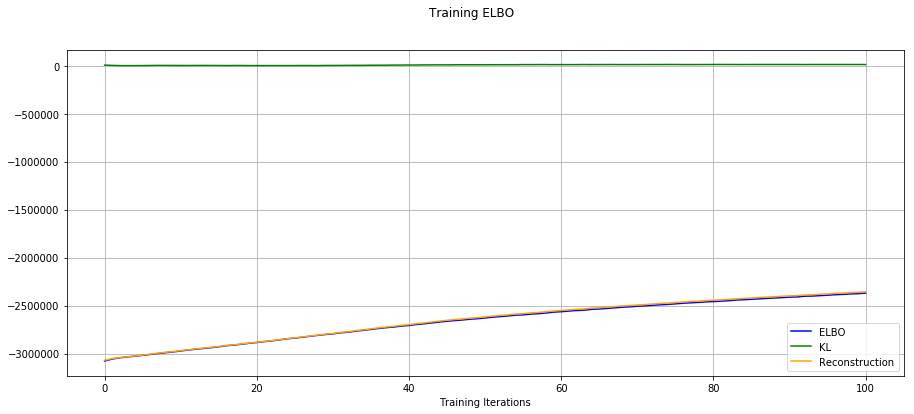

In [94]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls_y, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

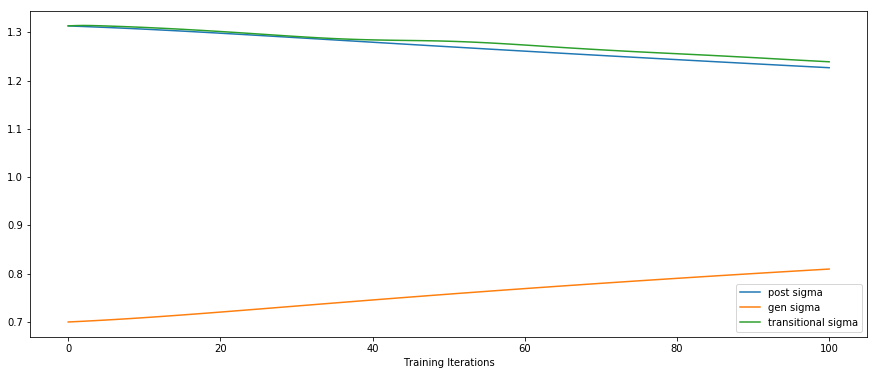

In [69]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='transitional sigma')
ax.set_xlabel('Training Iterations')
plt.legend();

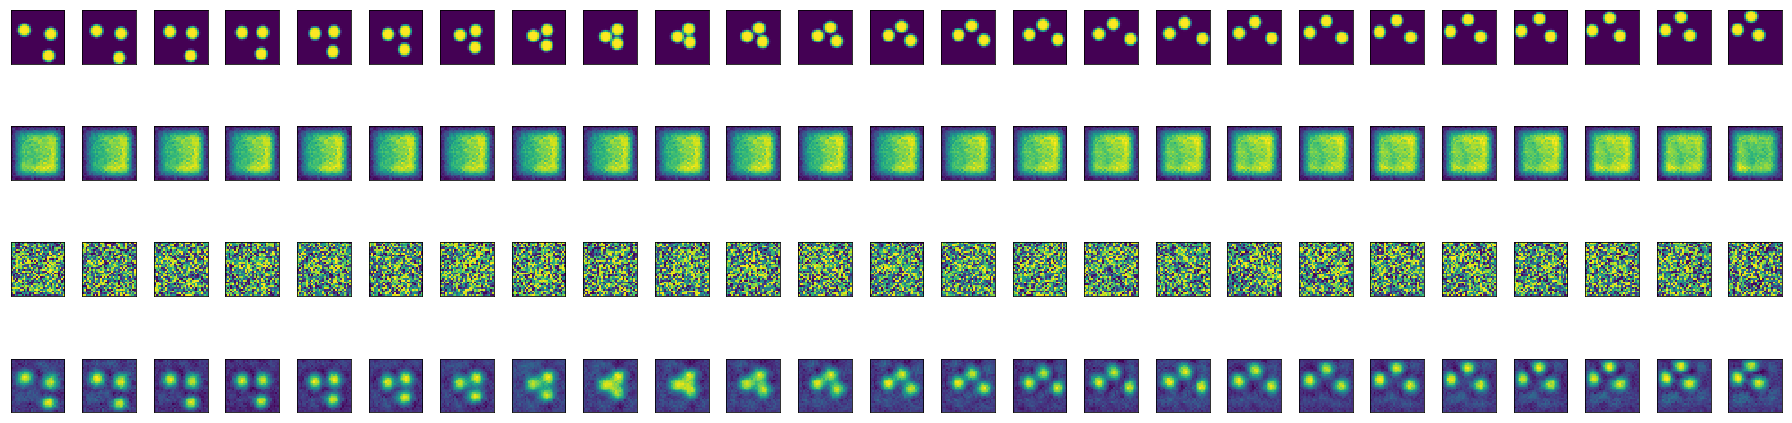

In [92]:
fig, axs = plt.subplots(nrows=4, ncols=25, figsize=(25, 7))
for j in range(25):
    axs[0][j].imshow(np.reshape(batch[0], [70, 30, 30])[j])    
#     axs[1][j].imshow(np.reshape(norm.cdf(training_data[0]), [100, 30, 30])[j])    
    axs[1][j].imshow(np.reshape(norm.cdf(np.mean(means[-1], (0, 1)))[0], [70, 30, 30])[j])
    axs[2][j].imshow(np.reshape(norm.cdf(latents[0, 0], 0), [70, 30, 30])[j])
    axs[3][j].imshow(np.reshape(norm.cdf(sess.run(gen_model.make_posterior_y.mean(), {x_: batch})[0]), [70, 30, 30])[j])
for i in range(4):
    for j in range(25):
        axs[i][j].set_xticks([]); axs[i][j].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Best forward pred at 10000 iters
code = sess.run(gen_model.make_forward_parameters, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(y_tilde[0, :seq_length], label='noisy data')
plt.plot(np.concatenate([y[:seq_length, 0], code], 0), 'r', label='prediction')
plt.plot(y[:seq_length+50], label='clean data')
plt.legend()
plt.suptitle("Best forward prediction");